In [1]:
lfsr_thresh = 0.00001

In [2]:
#common
%pylab inline

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

import pandas as pd

SAVEPLOT = True
datadir = "../mashr/fullrun/output/"
lfsr = pd.read_csv(datadir + "posterior_lfsr.tsv", sep="\t", index_col=0)
betas = pd.read_csv(datadir + "posterior_betas.tsv", sep="\t", index_col=0)
beta_ses = pd.read_csv(datadir + "posterior_beta_ses.tsv", sep="\t", index_col=0)
ntissues = len(lfsr.columns)

COLORS = {
    "Artery-Aorta":"salmon",
    "Artery-Tibial": "red",
    "Adipose-Subcutaneous": "darkorange",    
    "Adipose-Visceral":"orange",
    "Brain-Caudate":"lemonchiffon"   , 
    "Brain-Cerebellum":"yellow",
    "Cells-Transformedfibroblasts": "skyblue",
    "Esophagus-Mucosa": "sienna",
    "Esophagus-Muscularis":"burlywood",
    "Heart-LeftVentricle":"darkviolet",
    "Lung": "greenyellow",
    "Muscle-Skeletal": "mediumslateblue",
    "Nerve-Tibial":"gold",
    "Skin-NotSunExposed":"blue",
    "Skin-SunExposed":"cornflowerblue",
    "Thyroid":"green",
    "WholeBlood": "m",
    "permuted": "gray"
}

SHORTEN = {
    "Artery-Aorta":"Artery A."     ,
    "Artery-Tibial": "Artery T.",
    "Adipose-Subcutaneous": "Adipose S.",    
    "Adipose-Visceral":"Adipose V.",
    "Brain-Caudate":"Caudate"   , 
    "Brain-Cerebellum":"Cerebellum",
    "Cells-Transformedfibroblasts": "Fibroblast",
    "Esophagus-Mucosa": "E. Mucosa",
    "Esophagus-Muscularis":"E Muscularis",
    "Heart-LeftVentricle":"Ventricle",
    "Lung": "Lung",
    "Muscle-Skeletal": "Muscle",
    "Nerve-Tibial":"Nerve",
    "Skin-NotSunExposed": "Skin Unexposed",
    "Skin-SunExposed":"Skin Leg",
    "Thyroid":"Thyroid",
    "WholeBlood": "Blood",
    "permuted":"Permuted",
    "LCL": "LCL"
}

Populating the interactive namespace from numpy and matplotlib


In [3]:
#number of significant eSTRs
significantESTRs = (lfsr <= lfsr_thresh).apply(any, axis=1) #significant in any tissue
print("Number of significant eSTRs:", np.sum(significantESTRs))

Number of significant eSTRs: 16972


In [4]:
#lfsr effect sharing per gene

geneToNumESTRs = {}
def addIfGene(row):
    geneName = row.iloc[0].split("_")[0]
    if not geneName in geneToNumESTRs:
        geneToNumESTRs[geneName] = 0
    if type(row.iloc[1]) != type(False):
        print(row)
    geneToNumESTRs[geneName] += row.iloc[1] 
significantESTRs.reset_index().apply(addIfGene, axis=1)
pass

In [5]:
len(geneToNumESTRs)

13843

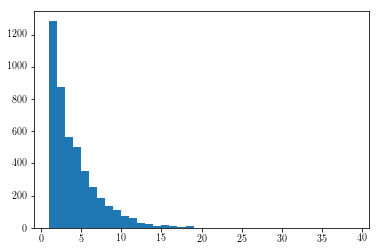

In [7]:
fig, ax = plt.subplots()
im = ax.hist(list(geneToNumESTRs.values()), bins=range(1,40))
#ax.set_yscale()

In [4]:
#Heatmaps

#Result is similar by pattern to mashr fig 6 https://www.nature.com/articles/s41588-018-0268-8#MOESM1
#shared significance threshold (e.g. must be within 2x of each other, must be >1)
sharing_thresh = 2

#order same as (subset of) fig2a https://www.nature.com/articles/nature24277.pdf
ORDER = [ \
    'Brain-Caudate',
    'Brain-Cerebellum',
    'WholeBlood',
    'Cells-Transformedfibroblasts',
    'Muscle-Skeletal',
    'Heart-LeftVentricle',
    'Esophagus-Mucosa',
    'Skin-NotSunExposed',
    'Skin-SunExposed',
    'Thyroid',
    'Esophagus-Muscularis',
    'Artery-Aorta',
    'Artery-Tibial',
    'Lung',
    'Nerve-Tibial',     
    'Adipose-Subcutaneous',
    'Adipose-Visceral'
]

for i in range(len(ORDER)):
    ORDER[i] = ORDER[i].replace("-", ".")
o_lfsr = lfsr.loc[:, ORDER]
o_betas = betas.loc[:, ORDER]
    
shareMatrix = np.full((ntissues, ntissues), np.nan)
for tissue1 in np.arange(ntissues):
    for tissue2 in np.arange(tissue1):
        significant = (o_lfsr.iloc[:, tissue1] <= lfsr_thresh) | (o_lfsr.iloc[:, tissue2] <= lfsr_thresh)
        sharedEffects = ((o_betas.iloc[:, tissue1] <= sharing_thresh*o_betas.iloc[:, tissue2]) & \
                         (o_betas.iloc[:, tissue2] <= sharing_thresh*o_betas.iloc[:, tissue1]))
        shareMatrix[tissue2, tissue1] = np.sum(sharedEffects & significant)/np.sum(significant)

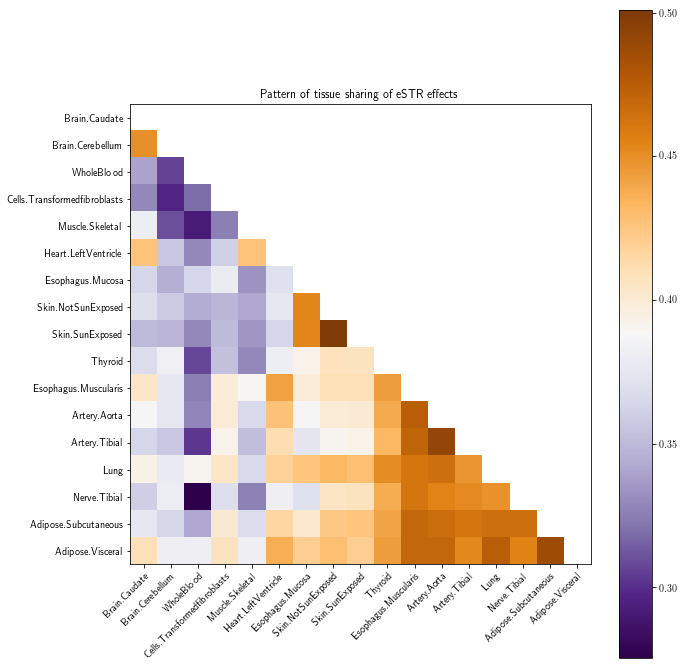

In [6]:
from matplotlib.colors import Colormap
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(shareMatrix.T, cmap="PuOr_r")
fig.colorbar(im)

# We want to show all ticks...
ax.set_xticks(np.arange(ntissues))
ax.set_yticks(np.arange(ntissues))
# ... and label them with the respective list entries
ax.set_xticklabels(o_lfsr.columns.values)
ax.set_yticklabels(o_lfsr.columns.values)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

'''
# Loop over data dimensions and create text annotations.
for i in range(len(lfsr.columns)):
    for j in range(len(lfsr.columns)):
        text = ax.text(j, i, shareMatrix[i, j],
                       ha="center", va="center", color="w")
'''    

ax.set_title("Pattern of tissue sharing of eSTR effects")
fig.tight_layout()
plt.show()

#correlation


In [ ]:
#lfsr effect sharing per tissue